In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config["database.host"] = '134.2.168.16'
dj.config['schema_name'] = "nnfabrik_monkey_mei"
schema = dj.schema("nnfabrik_monkey_mei")

import os
from os import listdir
from os.path import isfile, join

import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.from_nnfabrik import DataInfo

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

Connecting DKessler@134.2.168.16:3306


In [2]:
# nnfabrik main
from nnvision.tables.main import MonkeyExperiment
from nnvision.tables.from_mei import TrainedEnsembleModel, MEIMethod
from featurevis.main import MEITemplate
from nnvision.tables.measures import OracleScore

@schema
class MEI_update(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = MonkeyExperiment.Units

In [3]:
# parameters
dataset_hash='a737408da40cfedd036c2eb1b8a31ff1'
ensemble_hash='e7a8d0b961ee37ffda0779bfed95f1cf'

data_key='3631807112901'                   

In [4]:
# get the model 
model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model = TrainedModel().load_model(model_key, include_dataloader=False)
model.eval()

# model readout coordinates from -1, 1 
model_readout_pos = model.readout[data_key].grid  # needs to be converted to canvas size by min-max-normalization

In [5]:
n_units = model.readout[data_key].outdims  # number of model neurons 
total_trials = 30                          # for optimization

unit_idx = 27                              # arbitrary model neuron
unit_id = 28

# image dimensions:
h, w = 41, 41

# Toy Experiment Bar Stimulus ("End-stopping")

In [6]:
unit_idx = 27

# specify parameter set
bar_set = BarsSet(canvas_size = [w, h], 
                  locations = UniformRange([[8.0, 32.0], [8.0, 32.0]]), 
                  lengths = FiniteParameter([float(val) for val in range(12, 30)]), 
                  widths = FiniteParameter([float(val) for val in range(4, 12)]), 
                  contrasts = UniformRange([-1.0, 1.0]), 
                  orientations = UniformRange([0.0, np.pi]), 
                  grey_levels = FiniteParameter([0.0]))


In [7]:
# Find optimal bar for given neuron
params, vals = bar_set.find_optimal_stimulus(model, data_key, unit_idx)

[INFO 10-28 19:04:29] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 10-28 19:04:29] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 10-28 19:04:29] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-28 19:04:29] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-28 19:04:29] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-28 19:04:30] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-28 19:04:30] ax.service.managed_loop: Running optimization trial 5...
[INFO 10-28 19:04:30] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-28 19:04:30] ax.service.managed_loop: Running optimization trial 7...
[INFO 10-28 19:04:30] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-28 19:04:30] ax.service.managed_loop: Running optimization trial 9...
[INFO 10-28 19:04:31] ax.service.managed_loop: Running optimization trial 10...
[INFO 10-28 19:04:31] ax.service.ma

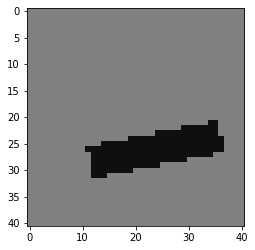

In [8]:
# plot optimal bar stimulus
img = bar_set.get_image_from_params(params)
plt.imshow(img, cmap="gray", vmin=-1, vmax=1)

In [9]:
params

{'location_width': 23.748755410313606,
 'location_height': 26.0627828463912,
 'contrast': -0.8826166577637196,
 'orientation': 1.7652816330999783,
 'length': 25.0,
 'width': 6.0,
 'grey_level': 0.0}

In [10]:
# Tuning curves for bar length
length_values = list(range(8, 36))[::2]

bar_set_length = BarsSet(canvas_size = [w, h], 
                         locations = FiniteParameter([[params['location_width'], params['location_height']]]),
                         lengths = FiniteParameter(length_values), 
                         widths = FiniteParameter([params['width']]), 
                         contrasts = FiniteParameter([params['contrast']]), 
                         orientations = FiniteParameter([params['orientation']]),  
                         grey_levels = FiniteParameter([params['grey_level']])) 


In [11]:
# Plaids Experiment - Show images to model neurons

activations_unit = np.array([])

# show the stimuli with varying orientation to the model and store its response 
unit_name = "unit_" + str(unit_idx)
for batch in bar_set_length.image_batches(batch_size=100):
    images_batch = np.expand_dims(batch, axis=1)
    images_batch = torch.tensor(images_batch).float()
    activations_batch = model(images_batch, data_key=data_key).detach().numpy().squeeze()[:, unit_idx]
    activations_unit = np.hstack([activations_unit, activations_batch])

Text(0.5, 1.0, 'Length Tuning - Bar Stimulus')

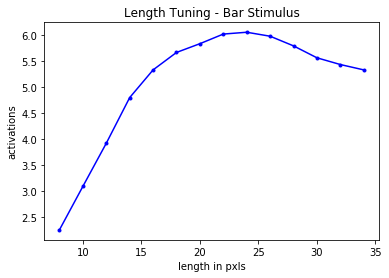

In [12]:
# tuning curve
plt.plot(length_values, activations_unit, '.-b')
plt.ylabel("activations")
plt.xlabel('length in pxls')
plt.title("Length Tuning - Bar Stimulus")

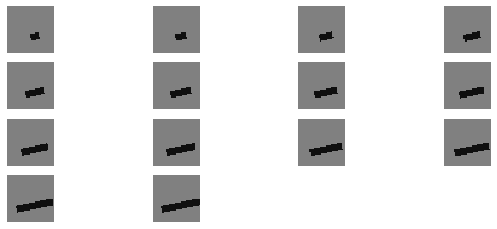

In [13]:
plt.figure(figsize=(10, 5))

for i, img in enumerate(bar_set_length.images()):
    plt.subplot(5, 4, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')